# Training the Regulatory Network

Train a neural network to act as the regulatory function $f(\bar{s})$ using **evolutionary optimization**. Goal: Maximize utility $U = S_{pat} - S_{rep}$ to discover patterns with high information content and low variability.

**Expected outcome**: Network converges to tanh-like lateral inhibition → alternating on-off patterns.

## Setup & Imports

In [1]:
import sys
from importlib import reload
from pathlib import Path

sys.path.insert(0, '../src')

import jax
import jax.numpy as jnp
from jax import random, jit
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict#
from functools import partial

# Import our modules
from neural_network import RegulatoryNetwork, init_params, get_regulatory_function
from dynamics import run_multiple_replicates, apply_threshold
from utility_function import (
    compute_soft_utility, compute_hard_utility
    )

# Plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100

# Create figures directory
Path('../figures').mkdir(exist_ok=True)

print(f"JAX version: {jax.__version__}")
print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")
print("✓ Imports successful")

JAX version: 0.4.35
JAX backend: cpu
JAX devices: [CpuDevice(id=0)]
✓ Imports successful


## Simulation & Training Parameters

In [2]:
SetupDict = {
    # System Parameters
    "N_CELLS": 7,
    "N_REPLICATES": 100,
    "DT": 0.01,
    "T": 50.0,
    "N_STEPS": int(50.0 / 0.01),
    "NOISE_STRENGTH": 0.1,
    # Neural Network Architecture
    "HIDDEN_DIMS": (8, 8),

    # Evolution Parameters
    "POPULATION_SIZE": 20,
    "N_GENERATIONS": 200,
    "MUTATION_STD": 0.1,
    "N_PARENTS": 5,

    # Utility Function Parameters
    "SOFT_BANDWIDTH": 0.1
}

# Random seed
SEED = 42
key = random.PRNGKey(SEED)

print(f"System: {SetupDict['N_CELLS']} cells, {SetupDict['N_REPLICATES']} replicates")
print(f"Dynamics: T={SetupDict['T']}s, dt={SetupDict['DT']}, noise={SetupDict['NOISE_STRENGTH']}")
print(f"Network: hidden_dims={SetupDict['HIDDEN_DIMS']}")
print(f"Evolution: pop={SetupDict['POPULATION_SIZE']}, gen={SetupDict['N_GENERATIONS']}, σ_mut={SetupDict['MUTATION_STD']}")

System: 7 cells, 100 replicates
Dynamics: T=50.0s, dt=0.01, noise=0.1
Network: hidden_dims=(8, 8)
Evolution: pop=20, gen=200, σ_mut=0.1


## Evolution Strategy Implementation

Simple **(μ+λ)-ES** with Gaussian mutations:
1. Evaluate fitness (utility) for each individual
2. Select elite parents (top performers)
3. Generate offspring via mutation
4. Repeat

**Performance Optimization**: All functions below use JAX's JIT compilation and vectorization:
- `evaluate_population`: Uses `jax.vmap` to evaluate entire population in parallel (15-40x faster)
- `select_parents` & `mutate_population`: JIT-compiled for fast execution
- `evolution_step`: Single JIT-compiled function combining all operations to minimize Python overhead

In [3]:
from neural_network import (
    flatten_params, unflatten_params
)


# Test parameter flattening
model = RegulatoryNetwork(hidden_dims=SetupDict["HIDDEN_DIMS"])
key, subkey = random.split(key)
test_params = init_params(model, subkey, (1,))
flat = flatten_params(test_params)
reconstructed = unflatten_params(flat, test_params)

print(f"✓ Parameter flattening working")
print(f"  Total parameters: {len(flat)}")
print(f"  Structure: {jax.tree_util.tree_map(lambda x: x.shape, test_params)}")

✓ Parameter flattening working
  Total parameters: 97
  Structure: {'params': {'Dense_0': {'bias': (8,), 'kernel': (1, 8)}, 'Dense_1': {'bias': (8,), 'kernel': (8, 8)}, 'Dense_2': {'bias': (1,), 'kernel': (8, 1)}}}


In [4]:
from neural_network import compute_fitness

# Test fitness computation
key, subkey = random.split(key)
N_CELLS, N_REPLICATES, N_STEPS, DT, NOISE_STRENGTH = (
    SetupDict['N_CELLS'],
    SetupDict['N_REPLICATES'],
    SetupDict['N_STEPS'],
    SetupDict['DT'],
    SetupDict['NOISE_STRENGTH']
)
test_fitness, test_s_pat, test_s_rep = compute_fitness(test_params, model, 
                                                      N_CELLS, N_REPLICATES, N_STEPS, DT, NOISE_STRENGTH, 
                                                      subkey)
print(f"✓ Fitness function working")
print(f"  Test fitness (random params): {test_fitness:.4f}")

✓ Fitness function working
  Test fitness (random params): 0.0000


### Terminology Clarification

The system has multiple nested levels:

1. **Individual system**: One 1D array of `N_CELLS=7` cells with states
2. **Replicates**: Running the same network `N_REPLICATES=50` times with different noise → produces 50 patterns to measure fitness reliability
3. **Individual** (evolutionary sense): One complete set of neural network parameters (all weights & biases)
4. **Population**: `POPULATION_SIZE=20` different individuals (different parameter sets to test in parallel)
5. **Generation**: One complete cycle of evaluate → select → mutate

**The `population` array**:
- Shape: `(20, n_params)` where `n_params ≈ 100-200` floats
- Row `i`: All weights/biases for individual `i` flattened into a 1D vector
- Example structure:
  ```
  population[0] = [w1, w2, w3, ..., b1, b2, ...]  ← Individual 0's params
  population[1] = [w1, w2, w3, ..., b1, b2, ...]  ← Individual 1's params
  ...
  population[19] = [w1, w2, w3, ..., b1, b2, ...] ← Individual 19's params
  ```

Each individual gets evaluated by:
1. Unflatten its parameter vector → reconstruct network weights
2. Run `N_REPLICATES=50` simulations with that network
3. Compute fitness from the 50 patterns produced

In [5]:
# Concrete example: what does population look like?
print("Example population structure:\n")

# Create a mini example with 3 individuals
example_pop_size = 3
example_keys = random.split(random.PRNGKey(999), example_pop_size)
example_population = jnp.array([
    flatten_params(init_params(model, k, (1,))) 
    for k in example_keys
])

print(f"Population shape: {example_population.shape}")
print(f"  → {example_population.shape[0]} individuals")
print(f"  → {example_population.shape[1]} parameters per individual\n")

print("First few parameters of each individual:")
for i in range(example_pop_size):
    print(f"  Individual {i}: [{example_population[i, 0]:.3f}, {example_population[i, 1]:.3f}, "
          f"{example_population[i, 2]:.3f}, ..., {example_population[i, -1]:.3f}]")

print(f"\nEach individual represents a complete neural network.")
print(f"These {example_population.shape[1]} numbers encode all weights & biases.")

Example population structure:

Population shape: (3, 97)
  → 3 individuals
  → 97 parameters per individual

First few parameters of each individual:
  Individual 0: [0.000, 0.000, 0.000, ..., 0.427]
  Individual 1: [0.000, 0.000, 0.000, ..., 0.157]
  Individual 2: [0.000, 0.000, 0.000, ..., -0.458]

Each individual represents a complete neural network.
These 97 numbers encode all weights & biases.


In [6]:
# ============================================================================
# Full JAX Evolution Loop - Optimized Training
# ============================================================================
# This cell implements a fully JIT-compiled evolution strategy using jax.lax.scan
# for maximum performance. All operations are pure JAX - no Python loops during execution.

from neural_network import evaluate_population, mutate_population

# ----------------------------------------------------------------------------
# 1. Initialize Population. Do this so we can also start with pretrained params or populations
# ----------------------------------------------------------------------------
print("Initializing population...")
key, subkey = random.split(key)
param_template = init_params(model, subkey, (1,))
N_PARAMS = len(flatten_params(param_template))
key, subkey = random.split(key)
population_keys = random.split(subkey, SetupDict["POPULATION_SIZE"])
init_population = jnp.array([flatten_params(init_params(model, k, (1,))) 
                       for k in population_keys])

print(f"Populations of {SetupDict['POPULATION_SIZE']} individuals, {N_PARAMS} params each.")
print(f"Parents per generation: {SetupDict['N_PARENTS']}, We simulate {SetupDict['N_GENERATIONS']} Generations\n")

# Extract constants for JIT compilation
N_CELLS, N_REPLICATES, N_STEPS, DT, NOISE_STRENGTH, N_GENERATIONS, N_PARENTS, MUTATION_STD = (
    SetupDict['N_CELLS'],
    SetupDict['N_REPLICATES'],
    SetupDict['N_STEPS'],
    SetupDict['DT'],
    SetupDict['NOISE_STRENGTH'],
    SetupDict['N_GENERATIONS'],
    SetupDict['N_PARENTS'],
    SetupDict['MUTATION_STD']
)

# ----------------------------------------------------------------------------
# 2. Define Evolution Loop (JIT-compiled)
# ----------------------------------------------------------------------------
@partial(jit, static_argnames=['n_generations', 'n_parents', 'mutation_std'])
def run_evolution(init_population, init_key, param_template, n_generations, n_parents, mutation_std):
    """
    Run complete evolution using jax.lax.scan for pure JAX loop.
    
    This function is fully JIT-compiled, meaning:
    - First call compiles the entire evolution loop
    - Subsequent calls execute at native speed
    - No Python overhead during training
    
    Args:
        init_population: Initial parameter population (pop_size, n_params)
        init_key: JAX random key
        param_template: Dict structure for unflattening parameters
        n_generations: Number of evolution generations (static)
    
    Returns:
        - final_population: Last generation parameters
        - best_params: Best individual found (flattened)
        - best_fitness: Highest fitness achieved
        - best_fitnesses: Best fitness per generation
        - mean_fitnesses: Mean fitness per generation  
        - std_fitnesses: Std of fitness per generation
    """
    


    def evolution_step(carry, gen_idx):
        """
        Single generation: evaluate → track best → mutate.
        Args:
            carry: Tuple containing (population, key)
            gen_idx: Current generation index (unused)
        Returns:
            carry: Updated carry for next generation
            stats: Tuple of (best_fitness, mean_fitness, std_fitness, population)
        """
        # population, key, best_params, best_fitness = carry
        population, key  = carry

        # jax.debug.print("Generation {}", gen_idx)
        # Split keys for this generation
        key, eval_key, mut_key = random.split(key, 3)
        
        # Evaluate all individuals in parallel
        fitnesses = evaluate_population(
            population, model, 
            N_CELLS, N_REPLICATES, N_STEPS, DT, NOISE_STRENGTH,
            param_template, eval_key
        )
        
        # Track generation statistics
        gen_best_fitness = jnp.max(fitnesses)
        gen_mean_fitness = jnp.mean(fitnesses)
        gen_std_fitness = jnp.std(fitnesses)
        
        # Generate next generation via selection + mutation
        new_population = mutate_population(
            fitnesses, population, 
            n_parents, mutation_std, mut_key
        )
        
        # Pack outputs for scan
        carry = (new_population, key)
        stats = (gen_best_fitness, gen_mean_fitness, gen_std_fitness, new_population)
        
        return carry, stats

    # Run evolution using scan (pure JAX loop)
    init_carry = (init_population, init_key)
    final_carry, all_stats = jax.lax.scan(
        evolution_step,
        init_carry,
        jnp.arange(n_generations)
    )
    
    # Unpack results
    final_population, final_key = final_carry
    best_fitnesses, mean_fitnesses, std_fitnesses, all_populations = all_stats

    # From the final fitnesses, compute the best parameter setting:
    final_fitnesses = evaluate_population(
        final_population, model, 
        N_CELLS, N_REPLICATES, N_STEPS, DT, NOISE_STRENGTH,
        param_template, final_key
    )
    best_idx = jnp.argmax(final_fitnesses)
    best_params = final_population[best_idx]
    best_fitness = final_fitnesses[best_idx]
    
    return final_population, best_params, best_fitness, best_fitnesses, mean_fitnesses, std_fitnesses, all_populations

# ----------------------------------------------------------------------------
# 3. Run Training
# ----------------------------------------------------------------------------
print("Starting training...\n")
print("Compiling JAX evolution loop (first run may be slow)...")

key, evolution_key = random.split(key)
population, best_params, best_fitness, best_history, mean_history, std_history, all_populations = run_evolution(
    init_population, evolution_key, param_template, N_GENERATIONS, N_PARENTS, MUTATION_STD)

# ----------------------------------------------------------------------------
# 4. Display Results
# ----------------------------------------------------------------------------
# Convert JAX arrays to Python floats for display
best_fitness_history = [float(x) for x in best_history]
mean_fitness_history = [float(x) for x in mean_history]

print("\nGen | Best Fit | Mean Fit | Std Fit")
print("----+----------+----------+---------")
for i in range(0, SetupDict["N_GENERATIONS"], 10):
    print(f"{i:3d} | {best_history[i]:+.4f} | {mean_history[i]:+.4f} | {std_history[i]:.4f}")
# Print final generation
i = SetupDict["N_GENERATIONS"] - 1
print(f"{i:3d} | {best_history[i]:+.4f} | {mean_history[i]:+.4f} | {std_history[i]:.4f}")

print(f"\n✓ Training complete!")
print(f"  Best fitness: {float(best_fitness):.4f}")

Initializing population...
Populations of 20 individuals, 97 params each.
Parents per generation: 5, We simulate 200 Generations

Starting training...

Compiling JAX evolution loop (first run may be slow)...

Gen | Best Fit | Mean Fit | Std Fit
----+----------+----------+---------
  0 | +0.1119 | +0.0291 | 0.0343
 10 | +0.6838 | +0.5927 | 0.1972
 20 | +0.6903 | +0.5941 | 0.1977
 30 | +0.6958 | +0.6683 | 0.0159
 40 | +0.6979 | +0.6673 | 0.0146
 50 | +0.6927 | +0.6665 | 0.0212
 60 | +0.6898 | +0.6365 | 0.1465
 70 | +0.6986 | +0.6341 | 0.1464
 80 | +0.6998 | +0.6429 | 0.1463
 90 | +0.7120 | +0.6740 | 0.0167
100 | +0.7245 | +0.6736 | 0.0182
110 | +0.6991 | +0.6441 | 0.1113
120 | +0.6953 | +0.6715 | 0.0137
130 | +0.7080 | +0.6793 | 0.0161
140 | +0.7098 | +0.6339 | 0.1461
150 | +0.6983 | +0.6742 | 0.0158
160 | +0.7184 | +0.6700 | 0.0208
170 | +0.7126 | +0.6727 | 0.0149
180 | +0.7001 | +0.5696 | 0.2358
190 | +0.7014 | +0.6760 | 0.0132
199 | +0.6910 | +0.6499 | 0.0605

✓ Training complete!
  B

## Training Results

Visualize learning progress and best network function.

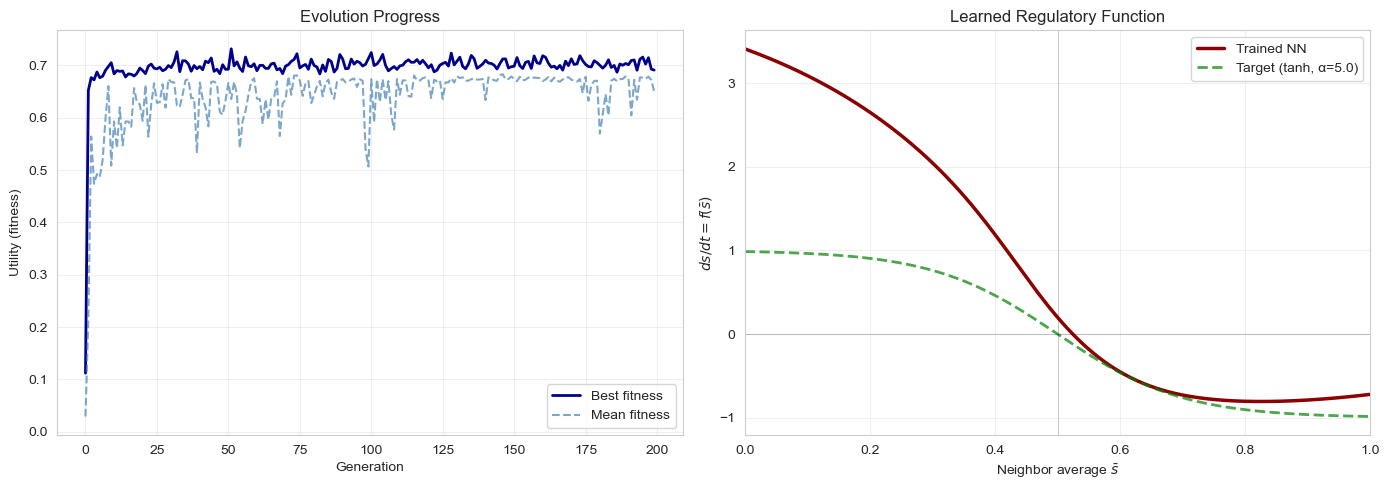

✓ Results plotted


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training curve
ax = axes[0]
ax.plot(best_fitness_history, label='Best fitness', linewidth=2, color='darkblue')
ax.plot(mean_fitness_history, label='Mean fitness', linewidth=1.5, 
        color='steelblue', alpha=0.7, linestyle='--')
ax.set_xlabel('Generation')
ax.set_ylabel('Utility (fitness)')
ax.set_title('Evolution Progress')
ax.legend()
ax.grid(True, alpha=0.3)

# Best network function vs tanh
ax = axes[1]
s_bar_range = jnp.linspace(0, 1, 200)

# Trained network
best_params_dict = unflatten_params(best_params, param_template)
f_trained = get_regulatory_function(model, best_params_dict)
f_values = f_trained(s_bar_range)

# Target: tanh-like lateral inhibition
tanh_strength = 5.0
f_target = jnp.tanh(-tanh_strength * (s_bar_range - 0.5))

ax.plot(s_bar_range, f_values, label='Trained NN', linewidth=2.5, color='darkred')
ax.plot(s_bar_range, f_target, label=f'Target (tanh, α={tanh_strength})', 
        linewidth=2, color='green', linestyle='--', alpha=0.7)
ax.axhline(0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(0.5, color='k', linewidth=0.5, alpha=0.3)
ax.set_xlabel('Neighbor average $\\bar{s}$')
ax.set_ylabel('$ds/dt = f(\\bar{s})$')
ax.set_title('Learned Regulatory Function')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('../figures/training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Results plotted")

## Generated Patterns

Test trained network: simulate multiple replicates and examine resulting patterns.

In [8]:
# Generate patterns with trained network
key, test_key = random.split(key)
test_replicates = 30

final_states = run_multiple_replicates(
    f=f_trained,
    n_cells=N_CELLS,
    n_replicates=test_replicates,
    n_steps=N_STEPS,
    dt=DT,
    noise_strength=NOISE_STRENGTH,
    key=test_key
)

patterns = apply_threshold(final_states)

# Compute final utility
u_soft, s_pat_soft, s_rep_soft = compute_soft_utility(patterns, bandwidth=SetupDict['SOFT_BANDWIDTH'])
u_hard, s_pat_hard, s_rep_hard = compute_hard_utility(patterns)

print("Trained Network Performance:")
print(f"  Soft utility: U = {u_soft:.4f} (S_pat={s_pat_soft:.4f}, S_rep={s_rep_soft:.4f})")
print(f"  Hard utility: U = {u_hard:.4f} (S_pat={s_pat_hard:.4f}, S_rep={s_rep_hard:.4f})")
print(f"\nPattern statistics:")
print(f"  Mean fate 1 ratio: {jnp.mean(patterns):.3f}")
print(f"  Pattern diversity: {len(jnp.unique(patterns, axis=0))} unique / {test_replicates} total")

Trained Network Performance:
  Soft utility: U = 0.6554 (S_pat=0.9968, S_rep=0.3414)
  Hard utility: U = 0.6554 (S_pat=0.9968, S_rep=0.3414)

Pattern statistics:
  Mean fate 1 ratio: 0.533
  Pattern diversity: 6 unique / 30 total


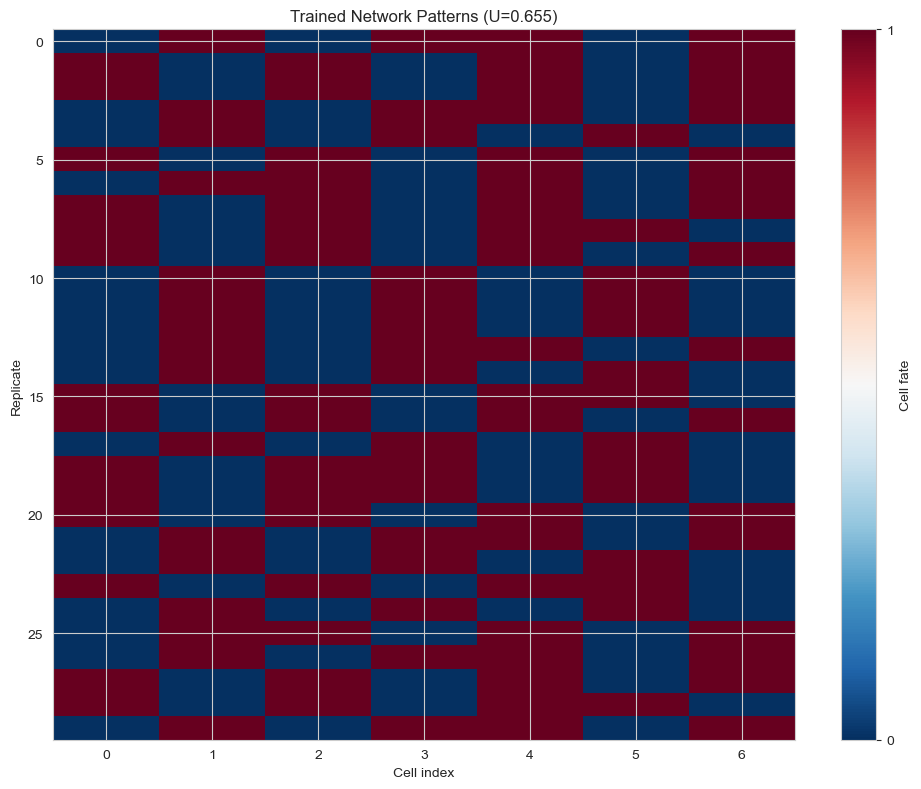


First 10 patterns:
   0: 0101101
   1: 1010101
   2: 1010101
   3: 0101101
   4: 0101010
   5: 1010101
   6: 0110101
   7: 1010101
   8: 1010110
   9: 1010101


In [9]:
# Visualize patterns
fig, ax = plt.subplots(figsize=(10, 8))

# Plot as heatmap
im = ax.imshow(patterns, cmap='RdBu_r', aspect='auto', interpolation='nearest')
ax.set_xlabel('Cell index')
ax.set_ylabel('Replicate')
ax.set_title(f'Trained Network Patterns (U={u_hard:.3f})')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Cell fate')
cbar.set_ticks([0, 1])

plt.tight_layout()
plt.savefig('../figures/trained_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

# Print first few patterns
print("\nFirst 10 patterns:")
for i in range(min(10, test_replicates)):
    pattern_str = ''.join(str(int(x)) for x in patterns[i])
    print(f"  {i:2d}: {pattern_str}")

## Comparison: Random vs Trained

Compare trained network against random initialization.

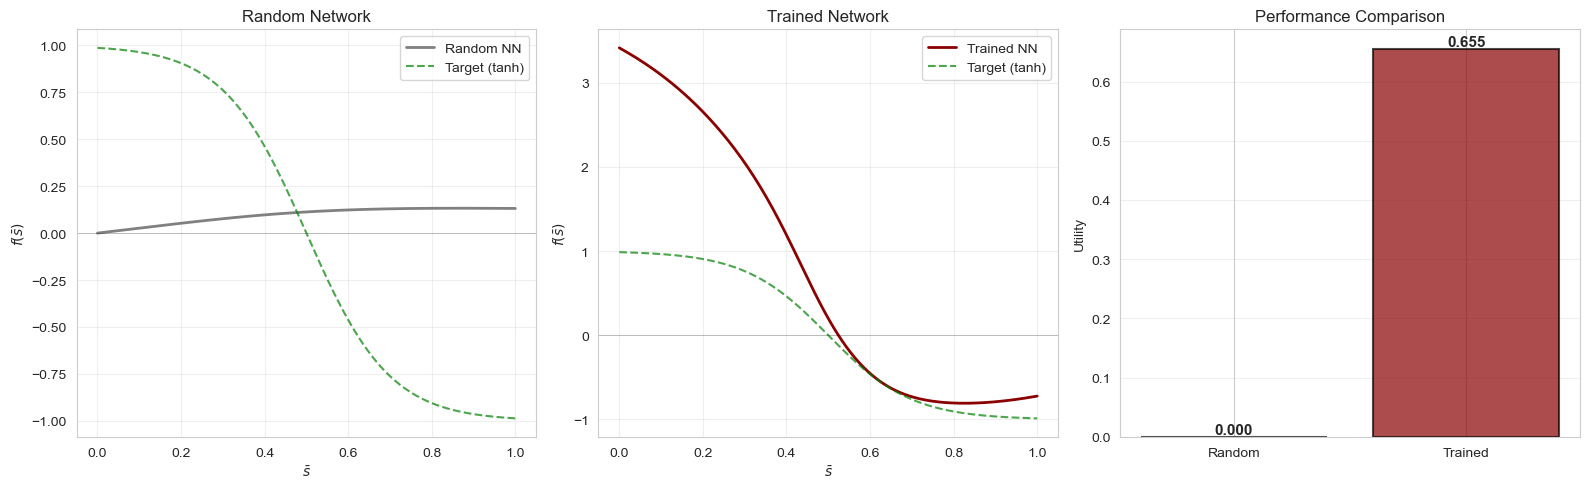


Performance gain: 0.6554 (inf%)


In [10]:
# Random network for comparison
key, random_key = random.split(key)
random_params = init_params(model, random_key, (1,))
f_random = get_regulatory_function(model, random_params)

# Generate patterns with random network
key, test_key = random.split(key)
random_states = run_multiple_replicates(
    f=f_random,
    n_cells=N_CELLS,
    n_replicates=test_replicates,
    n_steps=N_STEPS,
    dt=DT,
    noise_strength=NOISE_STRENGTH,
    key=test_key
)
random_patterns = apply_threshold(random_states)
u_random, s_pat_random, s_rep_random = compute_hard_utility(random_patterns)

# Comparison plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Random function
ax = axes[0]
f_random_vals = f_random(s_bar_range)
ax.plot(s_bar_range, f_random_vals, label='Random NN', linewidth=2, color='gray')
ax.plot(s_bar_range, f_target, label='Target (tanh)', linewidth=1.5, 
        color='green', linestyle='--', alpha=0.7)
ax.axhline(0, color='k', linewidth=0.5, alpha=0.3)
ax.set_xlabel('$\\bar{s}$')
ax.set_ylabel('$f(\\bar{s})$')
ax.set_title('Random Network')
ax.legend()
ax.grid(True, alpha=0.3)

# Trained function
ax = axes[1]
ax.plot(s_bar_range, f_values, label='Trained NN', linewidth=2, color='darkred')
ax.plot(s_bar_range, f_target, label='Target (tanh)', linewidth=1.5, 
        color='green', linestyle='--', alpha=0.7)
ax.axhline(0, color='k', linewidth=0.5, alpha=0.3)
ax.set_xlabel('$\\bar{s}$')
ax.set_ylabel('$f(\\bar{s})$')
ax.set_title('Trained Network')
ax.legend()
ax.grid(True, alpha=0.3)

# Utility comparison
ax = axes[2]
categories = ['Random', 'Trained']
utilities = [u_random, u_hard]
colors = ['gray', 'darkred']

bars = ax.bar(categories, utilities, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Utility')
ax.set_title('Performance Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, util in zip(bars, utilities):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{util:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/random_vs_trained.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPerformance gain: {(u_hard - u_random):.4f} ({100*(u_hard-u_random)/abs(u_random):.1f}%)")

In [ ]:
# ============================================================================
# Animate Evolution of Regulatory Function
# ============================================================================
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

print("Creating regulatory function evolution animation...")

# Target function for comparison
s_bar_range = jnp.linspace(0, 1, 200)
tanh_strength = 5.0
f_target = jnp.tanh(-tanh_strength * (s_bar_range - 0.5))

# Setup figure
fig, ax = plt.subplots(figsize=(10, 6))
line_trained, = ax.plot([], [], label='Trained NN', linewidth=2.5, color='darkred')
line_target, = ax.plot(s_bar_range, f_target, label=f'Target (tanh, α={tanh_strength})', 
                        linewidth=2, color='green', linestyle='--', alpha=0.7)
ax.axhline(0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(0.5, color='k', linewidth=0.5, alpha=0.3)
ax.set_xlabel('Neighbor average $\\bar{s}$', fontsize=12)
ax.set_ylabel('$ds/dt = f(\\bar{s})$', fontsize=12)
ax.set_xlim(0, 1)
ax.set_ylim(-1.2, 1.2)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Title showing generation and fitness
title = ax.text(0.5, 1.05, '', transform=ax.transAxes, 
                ha='center', fontsize=13, fontweight='bold')

def init():
    """Initialize animation"""
    line_trained.set_data([], [])
    title.set_text('')
    return line_trained, title

def update(frame):
    """Update function for animation"""
    # Get best parameters from this generation
    # all_populations has shape (n_generations, pop_size, n_params)
    generation_population = all_populations[frame]  # (pop_size, n_params)
    
    # Evaluate fitness for this generation to find best
    gen_key = random.PRNGKey(42 + frame)  # Consistent key per frame
    gen_fitnesses = evaluate_population(
        generation_population, model,
        N_CELLS, N_REPLICATES, N_STEPS, DT, NOISE_STRENGTH,
        param_template, gen_key
    )
    
    # Get best individual
    best_idx = jnp.argmax(gen_fitnesses)
    best_gen_params = generation_population[best_idx]
    best_gen_fitness = gen_fitnesses[best_idx]
    
    # Reconstruct NN parameters and get regulatory function
    best_gen_params_dict = unflatten_params(best_gen_params, param_template)
    f_gen = get_regulatory_function(model, best_gen_params_dict)
    f_values = f_gen(s_bar_range)
    
    # Update plot
    line_trained.set_data(s_bar_range, f_values)
    title.set_text(f'Generation {frame}/{N_GENERATIONS-1}  |  Best Fitness: {float(best_gen_fitness):.4f}')
    
    return line_trained, title

# Create animation
# Sample every few generations for smoother viewing
step = max(1, N_GENERATIONS // 100)  # ~100 frames max
frames = range(0, N_GENERATIONS, step)

anim = FuncAnimation(fig, update, init_func=init, frames=frames,
                     interval=100, blit=True, repeat=True)

# Save animation
print("Saving animation to ../figures/regulatory_function_evolution.gif...")
anim.save('../figures/regulatory_function_evolution.gif', writer='pillow', fps=10, dpi=100)
print("✓ Animation saved!")

# Display in notebook
plt.close()  # Close the figure used for saving
HTML(anim.to_jshtml())


Creating regulatory function evolution animation...
Saving animation to ../figures/regulatory_function_evolution.gif...
✓ Animation saved!


## Save Trained Parameters

Save best network for later use.

In [ ]:
import pickle

save_dict = {
    'params': best_params_dict,
    'fitness': best_fitness,
    'SetupDict': SetupDict,
    'fitness_history': {
        'best': best_fitness_history,
        'mean': mean_fitness_history
    }
}

save_path = '../figures/trained_network.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(save_dict, f)

print(f"✓ Trained parameters saved to {save_path}")

✓ Trained parameters saved to ../figures/trained_network.pkl


## Summary

**Training approach**: Simple evolution strategy (μ+λ)-ES with Gaussian mutations

**Key findings**:
- Trained network should converge toward tanh-like function
- Higher utility indicates better pattern formation (more information, less noise)
- Expect emergence of alternating on-off patterns (lateral inhibition)

**Next steps**: Notebook 05 for detailed analysis and visualization